## Accessing TerraClimate data with the Planetary Computer STAC API

[TerraClimate](http://www.climatologylab.org/terraclimate.html) is a dataset of monthly climate and climatic water balance for global terrestrial surfaces from 1958-2019. These data provide important inputs for ecological and hydrological studies at global scales that require high spatial resolution and time-varying data. All data have monthly temporal resolution and a ~4-km (1/24th degree) spatial resolution. The data cover the period from 1958-2019.

This example will show you how temperature has increased over the past 60 years across the globe.

### Environment setup

In [1]:
import warnings
import os
from scipy import spatial
from datetime import datetime
warnings.filterwarnings("ignore")
import geopandas as gpd
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

### Data access

https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate is a STAC Collection with links to all the metadata about this dataset. We'll load it with [PySTAC](https://pystac.readthedocs.io/en/latest/).

In [2]:
import pystac

url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate"
collection = pystac.read_file(url)
collection

<Collection id=terraclimate>

The collection contains assets, which are links to the root of a Zarr store, which can be opened with xarray.

In [3]:
asset = collection.assets["zarr-https"]
asset

<Asset href=https://cpdataeuwest.blob.core.windows.net/cpdata/raw/terraclimate/4000m/raster.zarr>

In [4]:
import fsspec
import xarray as xr

store = fsspec.get_mapper(asset.href)
ds = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
ds

,Array,Chunk
Bytes,103.45 GiB,94.92 MiB
Shape,"(744, 4320, 8640)","(12, 1440, 1440)"
Count,1117 Tasks,1116 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,103.45 GiB,94.92 MiB
Shape,"(744, 4320, 8640)","(12, 1440, 1440)"
Count,1117 Tasks,1116 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


We'll process the data in parallel using [Dask](https://dask.org).

In [5]:
pwd()

'/home/jovyan/final-project-team-ando-shravan-final_proj/scripts'

In [6]:
# from dask_gateway import GatewayCluster
%run helper.ipynb
setup_dask_cluster()

Clusters already exist, latching onto the first one
<Client: 'tls://10.244.169.9:8786' processes=2 threads=2, memory=32.00 GiB>
https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.1526d27ab1ed4f25b97258af4ce9d15d/status


In [7]:
countries = gpd.read_file(
    "https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson"
)

### Subset based on lat long of interest

In [8]:
#Subsetting based on the bounds of Costa Rica
# cr=ds.sel(lat=slice(11.209937,5.515082), lon=slice(-87.117665,-82.562837))
# cr=ds.sel(lat=slice(11.3,5.5), lon=slice(-87.2,-82.6))

cr=ds.sel(lat=slice(lat_max,lat_min), lon=slice(lon_min,lon_max))

In [9]:
# cr['tmax']
type(cr)

xarray.core.dataset.Dataset

The link printed out above can be opened in a new tab or the [Dask labextension](https://github.com/dask/dask-labextension). See [Scale with Dask](https://planetarycomputer.microsoft.com/docs/quickstarts/scale-with-dask/) for more on using Dask, and how to access the Dashboard.

### Analyze and plot global temperature

We can quickly plot a map of one of the variables. In this case, we are downsampling (coarsening) the dataset for easier plotting.

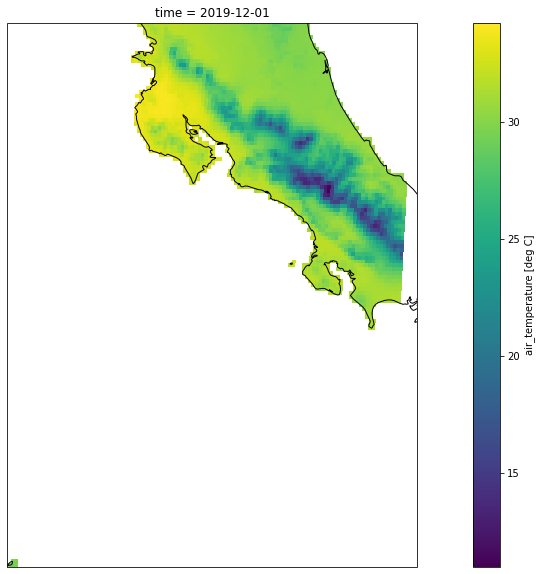

In [10]:
average_max_temp = cr.isel(time=-1)["tmax"].load()

fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(projection=ccrs.Robinson()))

average_max_temp.plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines();

Let's see how temperature has changed over the observational record, when averaged across the entire domain. Since we'll do some other calculations below we'll also add `.load()` to execute the command instead of specifying it lazily.  Note that there are some data quality issues before 1965 so we'll start our analysis there.

In [11]:
temperature = (
    cr["tmax"].sel(time=slice("2011", None)).mean(dim=["lat", "lon"]).persist()
)

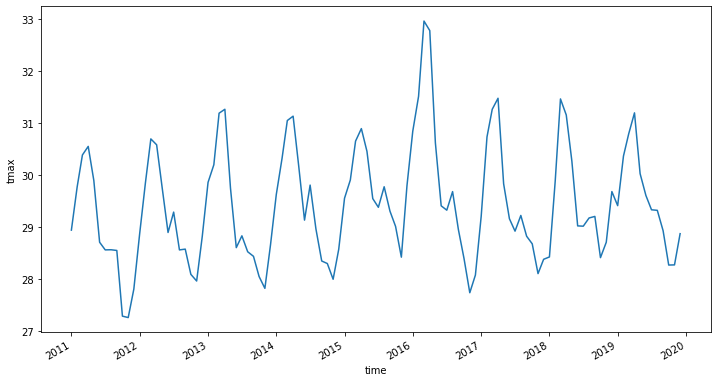

In [12]:
temperature.plot(figsize=(12, 6));

With all the seasonal fluctuations (from summer and winter) though, it can be hard to see any obvious trends. So let's try grouping by year and plotting that timeseries.

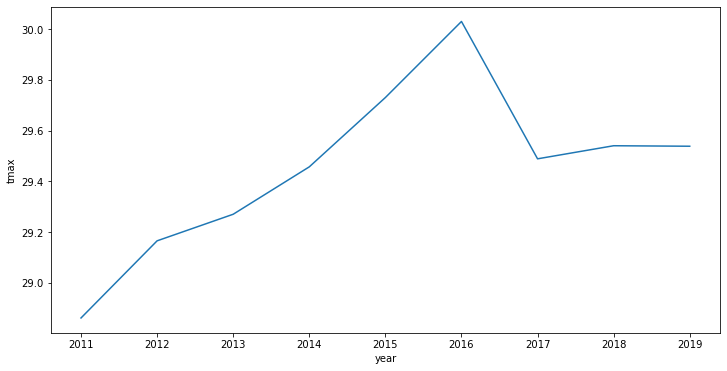

In [13]:
temperature.groupby("time.year").mean().plot(figsize=(12, 6));

Now the increase in temperature is obvious, even when averaged across the entire domain.

### Filteration based on high resolution Costa Rica

In [14]:
cr_polygon=countries[countries['ISO_A2']=='CR']

In [15]:
cr_polygon['geometry'] = cr_polygon['geometry'].set_crs("EPSG:4326")

In [16]:
import geopandas as gpd
from shapely.geometry import Polygon
import shapely as sh

<AxesSubplot:>

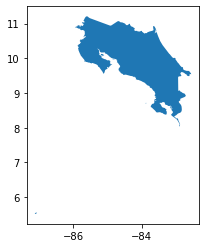

In [17]:
cr_core=cr_polygon.copy()
cr_core.plot()

In [18]:
cr_core.geometry.bounds

,minx,miny,maxx,maxy
53,-87.117665,5.515082,-82.562837,11.209937


In [19]:
type(cr_core), cr_core.head()

(geopandas.geodataframe.GeoDataFrame,
          ADMIN ISO_A3 ISO_A2  \
 53  Costa Rica    CRI     CR   
 
                                              geometry  
 53  MULTIPOLYGON (((-87.09903 5.51602, -87.11767 5...  )

In [20]:
list_data_vars=[i for i in cr.data_vars]

In [21]:
# Converting xarray dataframe (points) to geopandas dataframe
# def 
param=list_data_vars
xarr_df=cr

xarr = xarr_df[param]
df = xarr.to_dask_dataframe().reset_index(drop=True)

In [22]:
len(xarr_df)

18

### NA analysis
NA observed in ~52% data variables

In [23]:
df.isna().sum().compute()

time                            0
lat                             0
lon                             0
aet                       8929488
def                       8929488
pdsi                      8929488
pet                       8929488
ppt                       8929488
ppt_station_influence           0
q                         8929488
soil                      8929488
srad                      8929488
swe                       8929488
tmax                      8929488
tmax_station_influence          0
tmin                      8929488
tmin_station_influence          0
vap                       8929488
vap_station_influence           0
vpd                       8930320
ws                        8929488
dtype: int64

In [24]:
df_na=df[df.tmax.isna()].reset_index(drop=True)

In [25]:
df_na.head()

,time,lat,lon,aet,def,pdsi,pet,ppt,ppt_station_influence,q,...,srad,swe,tmax,tmax_station_influence,tmin,tmin_station_influence,vap,vap_station_influence,vpd,ws
0,1958-01-01,11.229167,-87.104167,NaN,NaN,NaN,NaN,NaN,8.0,NaN,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,5.0,NaN,NaN
1,1958-01-01,11.229167,-87.062500,NaN,NaN,NaN,NaN,NaN,8.0,NaN,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,5.0,NaN,NaN
2,1958-01-01,11.229167,-87.020833,NaN,NaN,NaN,NaN,NaN,8.0,NaN,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,5.0,NaN,NaN
3,1958-01-01,11.229167,-86.979167,NaN,NaN,NaN,NaN,NaN,8.0,NaN,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,5.0,NaN,NaN
4,1958-01-01,11.229167,-86.937500,NaN,NaN,NaN,NaN,NaN,8.0,NaN,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,5.0,NaN,NaN


In [26]:
 df_na.isna().sum().compute()

time                            0
lat                             0
lon                             0
aet                       8929488
def                       8929488
pdsi                      8929488
pet                       8929488
ppt                       8929488
ppt_station_influence           0
q                         8929488
soil                      8929488
srad                      8929488
swe                       8929488
tmax                      8929488
tmax_station_influence          0
tmin                      8929488
tmin_station_influence          0
vap                       8929488
vap_station_influence           0
vpd                       8929488
ws                        8929488
dtype: int64

In [27]:
# len(df)
# 5524944

In [28]:
2857704/5524944

0.5172367357931592

#### NA observed as "tmax_station_influence", "tmin_station_influence" and "vap_station_influence" variables are populated when required data variables aren't

Examining if the timeseries data is consistent in the non-NA dataset (all month-year data populated, and no month is left out)

In [29]:
df=df[~(df['tmax'].isna())].reset_index()

In [30]:
# df.time.min().compute(), df.time.max().compute()

In [31]:
start=datetime(1958,1,1)
end=datetime(2019,12,1)

12*(end.year-start.year)+(end.month-start.month)

743

In [32]:
len(df[['lat','lon']].drop_duplicates())
# 3585

3178

In [33]:
744*3585

2667240

In [34]:
2667240-744*3585

0

All lat-long coordinates have same number of time stamp!

In [35]:
lat_long_time_agg=df.groupby(['lat','lon']).time.nunique().reset_index().compute()

In [36]:
lat_long_time_agg.time.unique()

array([744])

### Filtering data for only the latest 5 years

In [37]:
df.columns

Index(['index', 'time', 'lat', 'lon', 'aet', 'def', 'pdsi', 'pet', 'ppt',
       'ppt_station_influence', 'q', 'soil', 'srad', 'swe', 'tmax',
       'tmax_station_influence', 'tmin', 'tmin_station_influence', 'vap',
       'vap_station_influence', 'vpd', 'ws'],
      dtype='object')

In [38]:
df_recent=df[df['time']>datetime(2014, 12,1)].reset_index(drop=True)

In [39]:
# len(df_recent)
# 215100

### Getting the average metrics and sd

In [40]:
df_agg = df_recent[['pdsi','ppt','soil', 'srad', 'tmax', 'tmin', 'vap','lat','lon']].groupby(['lat','lon']).agg([np.mean, np.std]).compute()

In [41]:
df_agg.reset_index(inplace=True)
df_agg.head()

lat        lon      pdsi                   ppt                   soil  \
                            mean       std        mean         std       mean   
0  5.520833 -87.104167  2.410000  2.471170  244.816667  237.811669  42.200000   
1  5.520833 -87.062500  2.528334  2.510189  231.950000  221.786840  41.433333   
2  5.520833 -87.020833  2.686667  2.413203  220.800000  239.721010  33.433333   
3  5.562500 -87.062500  2.586667  2.262252  208.500000  217.187456  31.850000   
4  5.562500 -87.020833  2.686667  2.300734  206.933333  218.616906  31.666667   

                    srad                  tmax                 tmin            \
         std        mean        std       mean       std       mean       std   
0  12.760904  197.783333  21.943713  29.851668  0.937069  21.060002  1.210561   
1  13.353558  196.683333  22.618052  29.461668  0.952101  20.560002  1.184244   
2  17.560903  201.866667  21.608588  29.895001  0.962600  21.025002  1.206138   
3  18.656416  203.966667  20.469903  30.241667  0.946984  21.348336  1.211732   
4  18.618987  203.883333  20.703803  29.958335  0.943877  21.030001  1.187834   

        vap            
       mean       std  
0  2.712667  0.142659  
1  2.651500  0.141143  
2  2.710833  0.142379  
3  2.752333  0.143141  
4  2.713333  0.141157

In [42]:
# len(df_agg)
# 3585

In [43]:
df_agg.columns=['lat', 'lon', 'pdsi_mean', 'pdsi_std', 'ppt_mean', 'ppt_std', 'soil_mean', 'soil_std', 'srd_mean', 
                'srad_std', 'tmax_mean', 'tmax_std', 'tmin_mean', 'tmin_std', 'vap_mean', 'vap_std']

In [44]:
df_agg.head()

,lat,lon,pdsi_mean,pdsi_std,ppt_mean,ppt_std,soil_mean,soil_std,srd_mean,srad_std,tmax_mean,tmax_std,tmin_mean,tmin_std,vap_mean,vap_std
0,5.520833,-87.104167,2.410000,2.471170,244.816667,237.811669,42.200000,12.760904,197.783333,21.943713,29.851668,0.937069,21.060002,1.210561,2.712667,0.142659
1,5.520833,-87.062500,2.528334,2.510189,231.950000,221.786840,41.433333,13.353558,196.683333,22.618052,29.461668,0.952101,20.560002,1.184244,2.651500,0.141143
2,5.520833,-87.020833,2.686667,2.413203,220.800000,239.721010,33.433333,17.560903,201.866667,21.608588,29.895001,0.962600,21.025002,1.206138,2.710833,0.142379
3,5.562500,-87.062500,2.586667,2.262252,208.500000,217.187456,31.850000,18.656416,203.966667,20.469903,30.241667,0.946984,21.348336,1.211732,2.752333,0.143141
4,5.562500,-87.020833,2.686667,2.300734,206.933333,218.616906,31.666667,18.618987,203.883333,20.703803,29.958335,0.943877,21.030001,1.187834,2.713333,0.141157


### Converting dataframe to geopandas df

In [45]:
data_vars_interest=['pdsi_mean', 'pdsi_std', 'ppt_mean', 'ppt_std', 'soil_mean', 'soil_std', 'srd_mean', 
                'srad_std', 'tmax_mean', 'tmax_std', 'tmin_mean', 'tmin_std', 'vap_mean', 'vap_std']

gdf = gpd.GeoDataFrame(
    df_agg[data_vars_interest], geometry=gpd.points_from_xy(df_agg.lon,df_agg.lat))

In [46]:
#setting crs
gdf=gdf.set_crs(epsg=4326, inplace=True)

<AxesSubplot:>

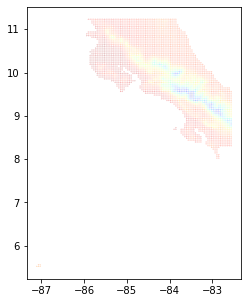

In [47]:
gdf.plot(markersize=0.01, figsize=(5,5), column='tmax_mean', cmap='jet')

AxesSubplot(0.215356,0.125;0.594288x0.755)


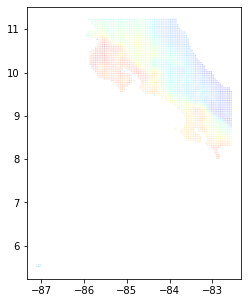

In [48]:
print(gdf.plot(markersize=0.01, figsize=(5,5), column='tmax_std', cmap='jet'))

In [49]:
import matplotlib.pyplot as plt
for i in data_vars_interest:
    print("Data variable:", i)
    gdf.plot(ax=ax, markersize=1, figsize=(6,6), column=i, cmap='jet', legend=True)
    plt.show()

Data variable: pdsi_mean


<Figure size 432x288 with 0 Axes>

Data variable: pdsi_std


<Figure size 432x288 with 0 Axes>

Data variable: ppt_mean


<Figure size 432x288 with 0 Axes>

Data variable: ppt_std


<Figure size 432x288 with 0 Axes>

Data variable: soil_mean


<Figure size 432x288 with 0 Axes>

Data variable: soil_std


<Figure size 432x288 with 0 Axes>

Data variable: srd_mean


<Figure size 432x288 with 0 Axes>

Data variable: srad_std


<Figure size 432x288 with 0 Axes>

Data variable: tmax_mean


<Figure size 432x288 with 0 Axes>

Data variable: tmax_std


<Figure size 432x288 with 0 Axes>

Data variable: tmin_mean


<Figure size 432x288 with 0 Axes>

Data variable: tmin_std


<Figure size 432x288 with 0 Axes>

Data variable: vap_mean


<Figure size 432x288 with 0 Axes>

Data variable: vap_std


<Figure size 432x288 with 0 Axes>

In [50]:
#Checking if the coordinate reference system is same
gdf.crs==cr_core.crs

True

In [51]:
#Filtering out "data for Costa Rica based on the high resolution polygon
cr_corr_vars = gpd.overlay(gdf, cr_core, how='intersection')

In [85]:
cr_corr_vars.shape

(2433, 18)

In [52]:
# len(cr_corr_vars)
#2431

### Generate arbitarary gridpoints

In [83]:
#Grid size: grid_size
grid_points=grid_point_generator(cr_core,[grid_size,grid_size])

In [84]:
grid_points.shape

(265536, 1)

### Filtering grid points in terrestrial Costa Rica

In [89]:
grid = get_gdf_with_grids(grid_points, grid_size)

In [94]:
grid.shape 

(265536, 1)

In [95]:
grids_overlap = gpd.clip(grid, cr_vec_hires)
grids_overlap.shape

(44276, 1)

In [ ]:
#Clipping based on points vs. grids
# grid_points_overlap = gpd.clip(grid_points, cr_vec_hires)
# grid_points_overlap.drop(['ADMIN', 'ISO_A3', 'ISO_A2'], axis=1, inplace=True)

In [88]:
# len(grid_points_overlap), len(grid_points)
# (43089, 265536)

(43089, 265536)

In [100]:
grids_overlap.reset_index(drop=True, inplace=True)
grids_overlap.head()

,geometry
0,"POLYGON ((-87.11272 5.52003, -87.10283 5.52003..."
1,"POLYGON ((-87.11272 5.52003, -87.11272 5.51533..."
2,"POLYGON ((-87.11272 5.52003, -87.11477 5.52003..."
3,"POLYGON ((-87.11272 5.52354, -87.10899 5.52992..."
4,"POLYGON ((-87.10283 5.52992, -87.09293 5.52992..."


### Nearest point (sjoin_nearest)

In [101]:
terra_grid_nearest = gpd.sjoin_nearest(grids_overlap, gdf)
len(terra_grid_nearest), len(grid_points_overlap)

(44276, 43089)

In [102]:
terra_grid_nearest.head(3)

,geometry,index_right,pdsi_mean,pdsi_std,ppt_mean,ppt_std,soil_mean,soil_std,srd_mean,srad_std,tmax_mean,tmax_std,tmin_mean,tmin_std,vap_mean,vap_std
0,"POLYGON ((-87.11272 5.52003, -87.10283 5.52003...",0,2.41,2.47117,244.816667,237.811669,42.2,12.760904,197.783333,21.943713,29.851668,0.937069,21.060002,1.210561,2.712667,0.142659
1,"POLYGON ((-87.11272 5.52003, -87.11272 5.51533...",0,2.41,2.47117,244.816667,237.811669,42.2,12.760904,197.783333,21.943713,29.851668,0.937069,21.060002,1.210561,2.712667,0.142659
2,"POLYGON ((-87.11272 5.52003, -87.11477 5.52003...",0,2.41,2.47117,244.816667,237.811669,42.2,12.760904,197.783333,21.943713,29.851668,0.937069,21.060002,1.210561,2.712667,0.142659


### Nearest Point (ckdTree)

In [103]:
gdf.reset_index(drop=True, inplace=True)
grid_points_overlap.reset_index(drop=True, inplace=True)

tree = spatial.cKDTree(np.c_[np.array(gdf.geometry.x), np.array(gdf.geometry.y)])
d,i=tree.query(np.c_[np.array(grid_points_overlap.geometry.x), np.array(grid_points_overlap.geometry.y)],1)

#i is the array containing the index of the nearest sparse grid points corresponding to each dense grid point
#d is the distance corresponding distance

In [104]:
gdf.head(3)

,pdsi_mean,pdsi_std,ppt_mean,ppt_std,soil_mean,soil_std,srd_mean,srad_std,tmax_mean,tmax_std,tmin_mean,tmin_std,vap_mean,vap_std,geometry
0,2.410000,2.471170,244.816667,237.811669,42.200000,12.760904,197.783333,21.943713,29.851668,0.937069,21.060002,1.210561,2.712667,0.142659,POINT (-87.10417 5.52083)
1,2.528334,2.510189,231.950000,221.786840,41.433333,13.353558,196.683333,22.618052,29.461668,0.952101,20.560002,1.184244,2.651500,0.141143,POINT (-87.06250 5.52083)
2,2.686667,2.413203,220.800000,239.721010,33.433333,17.560903,201.866667,21.608588,29.895001,0.962600,21.025002,1.206138,2.710833,0.142379,POINT (-87.02083 5.52083)


In [105]:
# closest=pd.DataFrame(i, columns=['grid_index'])
# closest['index']=closest['grid_index'].apply(lambda x: gdf.iloc[x]['index'])
# #closest is the dataframe containing mapping of indexes AND geometry of nearest sparse grid points for corresponding dense grid point 

In [106]:
# closest_all_vars=closest.merge(gdf, on='index', how='inner')
# closest_all_vars.head()

In [107]:
# closest_all_vars.rename(columns={'geometry': 'sparse_geometry'}, inplace=True)

### Using sjoin_nearest

In [108]:
#merging the closest_all_vars (which contains dense index + data vars of the nearest sparse grid point)

terra_cr=terra_grid_nearest

# terra_cr=pd.concat([grid_points_overlap, closest_all_vars], axis=1) #using ckdtree method
terra_cr.head()

,geometry,index_right,pdsi_mean,pdsi_std,ppt_mean,ppt_std,soil_mean,soil_std,srd_mean,srad_std,tmax_mean,tmax_std,tmin_mean,tmin_std,vap_mean,vap_std
0,"POLYGON ((-87.11272 5.52003, -87.10283 5.52003...",0,2.41,2.47117,244.816667,237.811669,42.2,12.760904,197.783333,21.943713,29.851668,0.937069,21.060002,1.210561,2.712667,0.142659
1,"POLYGON ((-87.11272 5.52003, -87.11272 5.51533...",0,2.41,2.47117,244.816667,237.811669,42.2,12.760904,197.783333,21.943713,29.851668,0.937069,21.060002,1.210561,2.712667,0.142659
2,"POLYGON ((-87.11272 5.52003, -87.11477 5.52003...",0,2.41,2.47117,244.816667,237.811669,42.2,12.760904,197.783333,21.943713,29.851668,0.937069,21.060002,1.210561,2.712667,0.142659
3,"POLYGON ((-87.11272 5.52354, -87.10899 5.52992...",0,2.41,2.47117,244.816667,237.811669,42.2,12.760904,197.783333,21.943713,29.851668,0.937069,21.060002,1.210561,2.712667,0.142659
4,"POLYGON ((-87.10283 5.52992, -87.09293 5.52992...",0,2.41,2.47117,244.816667,237.811669,42.2,12.760904,197.783333,21.943713,29.851668,0.937069,21.060002,1.210561,2.712667,0.142659


In [109]:
# import random
# test=terra_cr[['geometry', 'sparse_geometry']]
# test['lon_diff']=test['geometry'].x-test['sparse_geometry'].x
# test['lat_diff']=test['geometry'].y-test['sparse_geometry'].y
# random.seed(42)
# test.iloc[random.sample(range(len(test)), 20)]

In [110]:
terra_test_tiles = gpd.clip(terra_cr, cr_core)

In [111]:
len(terra_cr)

44276

<AxesSubplot:>

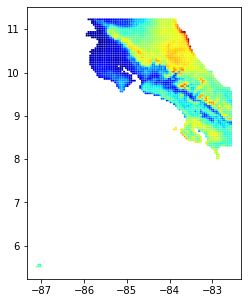

In [112]:
gdf.plot(markersize=1, figsize=(5,5), column='ppt_mean', cmap='jet')

<AxesSubplot:>

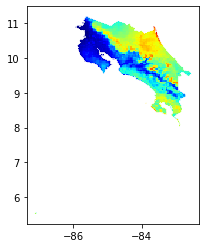

In [113]:
# terra_cr.iloc[random.sample(range(len(terra_cr)),30000)].plot(markersize=0.1, column='tmax_mean', cmap='jet', figsize=(10,10))
# terra_cr.plot(markersize=0.1, column='tmax_mean', cmap='jet', figsize=(40,40))
terra_cr.plot(markersize=0.1, column='ppt_mean', cmap='jet')

In [ ]:
import folium

cr_basemap = folium.Map(location=[9.859152, -83.996775], tiles='CartoDB positron' , zoom_start = 8)
terra_cr.explore(
    m = cr_basemap,
    column='tmax_mean',
    tooltip=['tmax_mean'],
    highlight=True,
    popup=True, # show all values in popup (on click)
    tiles="CartoDB positron", # use "CartoDB positron" tiles
    cmap="jet", # use "Set1" matplotlib colormap
    categorical = False,
    style_kwds=dict(color="black", apha=0.01, stroke=True) # use black outline
)

In [ ]:
terra_cr.head(2)

In [ ]:
# terra_cr.drop(['grid_index', 'index', 'level_0'], axis=1, inplace=True) # ckdtree method
# terra_cr_final=terra_cr.drop(['sparse_geometry'], axis=1)

# terra_cr.drop(['index_right', 'index', 'level_0'], axis=1, inplace=True) #sjoins method
# terra_cr.drop(['index'], axis=1, inplace=True)

In [ ]:
# .to_file("cr_terra_map.geojson", driver='GeoJSON')
terra_cr.drop(['index_right'], axis=1, inplace=True)
terra_cr.to_file("cr_terra_map.geojson", driver='GeoJSON')

In [ ]:
terra_cr.isna().sum()